In [14]:
from __future__ import division
import numpy as np
import mpmath
import scipy
import scipy.stats as sps
import scipy.fftpack as spfft
import scipy.signal as spsig
import scipy.optimize as spopt
import scipy.interpolate as spint
import matplotlib
from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)
import lmfit as lmfit

import math
import matplotlib.pyplot as plt
import um21_lagmodel as uml
%matplotlib notebook

# Set up list of colours that are more colour-blind accessible.
CBcol = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

In [2]:
disklag_data = np.loadtxt('tlags_111_gx339_04_2_3vs0p5_0p9keV59s.dat')
freq_data = (disklag_data[:,0]+disklag_data[:,1])/2.
dfreq_data = (disklag_data[:,1]-disklag_data[:,0])/2.
disktlags_data = disklag_data[:,2]/(2*dfreq_data)
disktlags_err_data = disklag_data[:,3]/(2*dfreq_data)

powlag_data = np.loadtxt('tlags_111_gx339_04_6_9vs2_3keV59s.dat')
powtlags_data = powlag_data[:,2]/(2*dfreq_data)
powtlags_err_data = powlag_data[:,3]/(2*dfreq_data)

diskpsd_fulldata = np.loadtxt('psd_111_gx339_04_0p5_0p9vs2_3keV59s.dat')
diskpsd_data = diskpsd_fulldata[:,2]/(2*dfreq_data)
diskpsd_err_data = diskpsd_fulldata[:,3]/(2*dfreq_data)
disknoise = np.mean(diskpsd_data[-8:]/freq_data[-8:])*freq_data

powspsd_fulldata = np.loadtxt('psd_111_gx339_04_2_3vs0p5_0p9keV59s.dat')
powspsd_data = powspsd_fulldata[:,2]/(2*dfreq_data)
powspsd_err_data = powspsd_fulldata[:,3]/(2*dfreq_data)
snoise = np.mean(powspsd_data[-8:]/freq_data[-8:])*freq_data

powhpsd_fulldata = np.loadtxt('psd_111_gx339_04_6_9vs2_3keV59s.dat')
powhpsd_data = powhpsd_fulldata[:,2]/(2*dfreq_data)
powhpsd_err_data = powhpsd_fulldata[:,3]/(2*dfreq_data)
hnoise = np.mean(powhpsd_data[-8:]/freq_data[-8:])*freq_data
diskpsd_data = diskpsd_data - disknoise
powspsd_data = powspsd_data - snoise
powhpsd_data = powhpsd_data - hnoise
diskvssoft_psdratio = diskpsd_data/powspsd_data
softvshard_psdratio = powspsd_data/powhpsd_data
diskvssoft_err_psdratio = diskpsd_err_data/powspsd_data
softvshard_err_psdratio = powspsd_err_data/powhpsd_data


In [3]:
def plot_data_lags_psds(lags_list, psds_list, vlines_list, axis_names, freqlim, freqlim_in, tlaglim, 
                        tlaglim_in, psdlim, inset_yticks, leg_title=None, figfile=None):
    
    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,8),sharex=True,gridspec_kw={'height_ratios':[5,3]})
    fig.subplots_adjust(hspace=0)
    ax3 = plt.axes([0,0,1,1])
    ip = InsetPosition(ax1, [0.65,0.62,0.32,0.37])
    ax3.set_axes_locator(ip)
    for i, x in enumerate(lags_list):
        freq = x[0]
        tlag = x[1]
        colour_val = x[2]
        ls_val = x[3]
        label_val = x[4]
        data_freq = x[5]
        data_tlag = x[6]
        data_tlag_err = x[7]
        data_label_val = x[8]
        data_present = x[9]
        ax1.plot(freq,tlag,color=colour_val,linewidth=3,linestyle=ls_val,label=label_val)
        ax3.plot(freq,tlag,color=colour_val,linewidth=3,linestyle=ls_val)
        if (data_present == True):
            if i == 0:
                ax1.errorbar(data_freq,data_tlag,yerr=data_tlag_err,color='red',marker='o',label=data_label_val)
                ax3.errorbar(data_freq,data_tlag,yerr=data_tlag_err,color='red',marker='o')
            if i == 1:
                ax1.errorbar(data_freq,data_tlag,yerr=data_tlag_err,color='black',marker='o',label=data_label_val)
                ax3.errorbar(data_freq,data_tlag,yerr=data_tlag_err,color='black',marker='o')            
    for i, x in enumerate(psds_list):
        freq = x[0]
        psd = x[1]
        colour_val = x[2]
        ls_val = x[3]
        label_val = x[4]
        data_freq = x[5]
        data_psd = x[6]
        data_psd_err = x[7]
        data_label_val = x[8]
        data_present = x[9]
        ax2.plot(freq,psd,color=colour_val,linewidth=3,linestyle=ls_val,label=label_val)
        if (data_present == True):
            if i == 0:
                ax2.errorbar(data_freq,data_psd,yerr=data_psd_err,color='red',marker='o',label=data_label_val)
            if i == 1:
                ax2.errorbar(data_freq,data_psd,yerr=data_psd_err,color='black',marker='o',label=data_label_val)
    if (vlines_list != None):
        for line in vlines_list:
            for ax in (ax1, ax2, ax3):
                ax.axvline(line[0],color=line[1],alpha=0.5,linewidth=3,linestyle=line[2])
    ax3.set_xlim(freqlim_in)
    ax3.set_ylim(tlaglim_in)
    ax3.set_xscale('log')
    ax3.set_yscale('linear')
    ax3.axhline(color='grey',linestyle='dotted')
    ax3.set_xticks([1,10])
    ax3.set_yticks(inset_yticks)
    ax2.set_xticklabels(ax2.get_xticks(), backgroundcolor='w')
    ax2.legend(fontsize=12,title=leg_title,title_fontsize=12)
    ax2.set_xlabel(axis_names[0],fontsize=14)
    ax1.set_ylabel(axis_names[1],fontsize=14)
    ax2.set_ylabel(axis_names[2],fontsize=14)
    ax3.set_xlabel(axis_names[0],fontsize=10)
    ax3.set_ylabel(axis_names[1],fontsize=10)
    ax1.set_yscale('log')
    ax2.set_yscale('log')
    ax2.set_xscale('log')
    ax2.set_xlim(freqlim)
    ax1.set_ylim(tlaglim)
    ax2.set_ylim(psdlim)
    for ax in (ax1, ax2, ax3):
        ax.tick_params(axis='x',labelsize=12, which='both', direction='in', top=True)
        ax.tick_params(axis='y',labelsize=12, which='both', direction='in', right=True)
        ax.tick_params(which='major', length=10)
        ax.tick_params(which='minor', length=6)
    if (figfile != None):
        plt.savefig(figfile,bbox_inches='tight')
    plt.show()

    return

def plot_data_lags(inputs, lags_list, vlines_list, axis_names, freqlim, freqlim_in, tlaglim, tlaglim_in, inset_yticks, 
                   leg_title=None, figfile=None):
    
    fig, ax1 = plt.subplots(1,1, figsize=(8,6))
    fig.subplots_adjust(hspace=0)
    ax2 = plt.axes([0,0,1,1])
    ip = InsetPosition(ax1, [0.65,0.62,0.32,0.37])
    ax2.set_axes_locator(ip)
    for i, x in enumerate(lags_list):
        freq = x[0]
        tlag = x[1]
        colour_val = x[2]
        ls_val = x[3]
        label_val = x[4]
        data_freq = x[5]
        data_tlag = x[6]
        data_tlag_err = x[7]
        data_label_val = x[8]
        if (inputs[0] == True):
            ax1.plot(freq,tlag,color=colour_val,linewidth=3,linestyle=ls_val,label=label_val)
            ax2.plot(freq,tlag,color=colour_val,linewidth=3,linestyle=ls_val)
        if (inputs[1] == True):
            if i == 0:
                ax1.errorbar(data_freq,data_tlag,yerr=data_tlag_err,color='red',marker='o',label=data_label_val)
                ax2.errorbar(data_freq,data_tlag,yerr=data_tlag_err,color='red',marker='o')
            if i == 1:
                ax1.errorbar(data_freq,data_tlag,yerr=data_tlag_err,color='black',marker='o',label=data_label_val)
                ax2.errorbar(data_freq,data_tlag,yerr=data_tlag_err,color='black',marker='o')            
    if (vlines_list != None):
        for line in vlines_list:
            for ax in (ax1, ax2):
                ax.axvline(line[0],color=line[1],alpha=0.5,linewidth=3,linestyle=line[2])
    ax2.set_xlim(freqlim_in)
    ax2.set_ylim(tlaglim_in)
    ax2.set_xscale('log')
    ax2.set_yscale('linear')
    ax2.axhline(color='grey',linestyle='dotted')
    ax2.set_xticks([1,10])
    ax2.set_yticks(inset_yticks)
    ax1.set_xticklabels(ax1.get_xticks(), backgroundcolor='w')
    ax1.legend(fontsize=12,title=leg_title,title_fontsize=12,loc='lower left')
    ax1.set_xlabel(axis_names[0],fontsize=14)
    ax1.set_ylabel(axis_names[1],fontsize=14)
    ax2.set_xlabel(axis_names[0],fontsize=10)
    ax2.set_ylabel(axis_names[1],fontsize=10)
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_xlim(freqlim)
    ax1.set_ylim(tlaglim)
    for ax in (ax1, ax2):
        ax.tick_params(axis='x',labelsize=12, which='both', direction='in', top=True)
        ax.tick_params(axis='y',labelsize=12, which='both', direction='in', right=True)
        ax.tick_params(which='major', length=10)
        ax.tick_params(which='minor', length=6)
    if (figfile != None):
        plt.savefig(figfile,bbox_inches='tight')
    plt.show()

    return

In [30]:
def calc_disk_band(disp_frac,cortodisk_frac,disktocor_frac,lseed_disp,lheat,thermal_frac,rcor,rad,rad_area,
                   eband,kTvar): 
    # Given the fractional of total flux due to 
    # dissipation, and the area
    # of each radial annulus of the disk, calculate the fraction of the flux at each radius which is emitted in a fixed
    # energy band, [E_min,E_max].  The energy band is defined not in absolute energy but relative to the maximum
    # blackbody temperature in the disk.  E.g. we observe an inner disk temperature of 0.3 keV and assume to probe 
    # this to correspond to the maximum.  If we then want to probe an energy range 0.6-0.9 keV, we should specify
    # eband = [2.0,3.0]
    
    f_rev = np.sum(cortodisk_frac) # The fraction of coronal luminosity that is reprocessed by the disk
    f_return = np.sum(cortodisk_frac*disktocor_frac) # the fraction of coronal luminosity that is reprocessed by the disk
    radldisk_rev = cortodisk_frac*thermal_frac*np.sum((lseed_disp+lheat)/(1-f_return))
    
    kT_rad = np.zeros(len(disp_frac))
    band_frac = np.zeros(len(disp_frac))
    kT_rad[rad > rcor] = ((disp_frac[rad > rcor]+
                                 radldisk_rev[rad > rcor])/rad_area[rad > rcor])**0.25
    kT_max = np.amax(kT_rad)
    kT_rad = kT_rad/kT_max
    
    E_min = eband[0]
    E_max = eband[1]
    # Total ph flux of bb_phlux for 1 keV = 2*Apery's constant *15/pi^4 for non-variable bb,
    # 1.5*Apery's constant *15/pi^4 for variable bb
    if kTvar == False:
        bb_phintnorm = 2*1.2020569031595942*15/np.pi**4 
    else:
        bb_phintnorm = 1.5*1.2020569031595942*15/np.pi**4 
    for i, radval in enumerate(rad):
        if radval > rcor:
            band_frac[i] = bb_phflux(E_min, E_max, kT_rad[i], 1000, kTvar)/(bb_phintnorm/kT_rad[i])
        
    ldiskband_disp = disp_frac*(1-disktocor_frac)*band_frac
    lseedband_disp = disp_frac*disktocor_frac*band_frac
    
    ldiskband_rev_arr = thermal_frac*band_frac*(cortodisk_frac*(1-
                    disktocor_frac))*(lseed_disp.reshape(len(rad),1)+lheat.reshape(len(rad),1))/(1-f_return)
    
    lseedband_rev_arr = thermal_frac*band_frac*(cortodisk_frac*disktocor_frac)*\
        (lseed_disp.reshape(len(rad),1)+lheat.reshape(len(rad),1))/(1-f_return)
    ldiskband_rev = np.sum(ldiskband_rev_arr,axis=1)
    lseedband_rev = np.sum(lseedband_rev_arr,axis=1)
    ldisk_band = ldiskband_disp + ldiskband_rev
    lseed_band = lseedband_disp + lseedband_rev
    
    return band_frac, kT_rad, ldisk_band, lseed_band, ldiskband_disp, ldiskband_rev

        
def bb_phflux(E_min, E_max, kT, nE, kTvar): # Calculates blackbody flux for blackbody with temperature kT and
    # integrated over an energy range E_min to E_max using nE discrete bins
    # The model is normalised to maintain a constant total energy flux regardless of kT (based on XSPEC bbody model)    

    E_edge = np.logspace(np.log10(E_min), np.log10(E_max), nE+1)
    E = np.sqrt(np.multiply(E_edge[1:],E_edge[:-1]))
    dE = E_edge[1:]-E_edge[:-1]
    if kTvar == False:
        bb_flux = np.sum((dE/E)*(E**3/kT**4)/(np.exp(E/kT)-1.))
    else:
        bb_flux = np.sum((dE/E)*(0.25*(E**4/kT**5)*np.exp(E/kT)*(np.exp(E/kT)-1)**-2))

    return bb_flux/((np.pi**4)/15)

def bb_enflux(E_min, E_max, kT, nE, kTvar): # Calculates blackbody flux for blackbody with temperature kT and
    # integrated over an energy range E_min to E_max using nE discrete bins
    # The model is normalised to maintain a constant total energy flux regardless of kT (based on XSPEC bbody model)    

    E_edge = np.logspace(np.log10(E_min), np.log10(E_max), nE+1)
    E = np.sqrt(np.multiply(E_edge[1:],E_edge[:-1]))
    dE = E_edge[1:]-E_edge[:-1]
    if kTvar == False:
        bb_flux = np.sum(dE*(E**3/kT**4)/(np.exp(E/kT)-1.))
    else:
        bb_flux = np.sum(dE*(0.25*(E**4/kT**5)*np.exp(E/kT)*(np.exp(E/kT)-1)**-2))

    return bb_flux/((np.pi**4)/15)


def bb_photflux(E_edge, kT, kTvar): # Calculates blackbody flux per bin for blackbody with 
    # temperature kT and calculated over an energy range E_min to E_max using nE discrete bins
    # The models are normalised to maintain a constant total flux regardless of kT (based on XSPEC bbody model)    
    # So should be multiplied by the local fractional mdot change to give change in blackbody emission
    # kTvar is a True/False flag for whether the linearised variable blackbody spectrum should be used vs
    # the non-variable ('time averaged') spectrum
    E = np.sqrt(np.multiply(E_edge[1:],E_edge[:-1]))
    dE = E_edge[1:]-E_edge[:-1]
    if kTvar == False:
        bb_flux = dE*(E**2/kT**4)/(np.exp(E/kT)-1.)
    else:
        bb_flux = dE*(0.25*(E**3/kT**5)*np.exp(E/kT)*(np.exp(E/kT)-1)**-2)

    return bb_flux


def lagmodel(params, freq_in, data_in, error_in, encomb_in, rout=1000, nrad=100, nphi=100, nz=400, 
             cor_geometry=uml.inv_cone, t_scale=5e-5, e_seed=1.0, ens_mono=np.array([1.,3.,9.]), 
             gamma_par=[2.33,0.167], band_calc=True, encomb=np.array([[2,0],[3,2]]), nirf_mult=8, 
             min_deltau_frac=1, freq_rsigmax=0.01, freq_range=[0.01,20.0], kTvar=True,
            psd_correct=True, lor_model='continuous'):
    
    rin = params['rin'].value
    rcor = params['rcor'].value
    hcor = params['hcor'].value
    cone_angle = params['cone_angle'].value
    seedff_norm = params['seedff_norm'].value
    thermal_frac = params['thermal_frac'].value
    pow_disk_frac = params['pow_disk_frac'].value
    disk_en = params['disk_en'].value
    band_mult = params['band_mult'].value
    disk_tau_norm = params['disk_tau_norm'].value   
    disk_tau_ind = params['disk_tau_ind'].value
    delay_tau_scale = params['delay_tau_scale'].value
    disp_ind = params['disp_ind'].value
    disksoft_psdnorm = params['disksoft_psdrat_norm'].value
    softhard_psdnorm = params['softhard_psdrat_norm'].value
    
    if lor_model == 'continuous':
        lor_q = params['lor_q1'].value
        
    if lor_model == 'multi_frequency':         
        lor_q1 = params['lor_q1'].value   
        lor_freq1 = params['lor_freq1'].value
        lor_rms1 = params['lor_rms1'].value
        lor_q2 = params['lor_q2'].value   
        lor_freq2 = params['lor_freq2'].value
        lor_rms2 = params['lor_rms2'].value
        lor_q3 = params['lor_q3'].value   
        lor_freq3 = params['lor_freq3'].value
        lor_rms3 = params['lor_rms3'].value

    
    heatff_norm = 1-seedff_norm
    seedff_ind = 0
    heatff_ind = 0
    disk_tau_par = [disk_tau_norm,disk_tau_ind]
    disk_prop_par = [disk_tau_norm*delay_tau_scale,disk_tau_ind]
    cor_tau_par = [disk_tau_norm,0]
    cor_prop_par = [0,0]
    if cor_geometry == uml.inv_cone:
        rtop = rcor + hcor*np.tan(np.pi*(np.array(cone_angle)/180))
        geopar = [rcor,hcor,rtop,nphi,nz]
    if cor_geometry == uml.an_sphere:
        geopar = [rcor]
    if lor_model == 'continuous':
        lor_par = [lor_q,0.4,0.0] # For continuous model: [q,total_rms_in_disk,total_rms_in_corona]
    if lor_model == 'multi_frequency':
        lor_par = [lor_freq1,lor_q1,lor_rms1,lor_freq2,lor_q2,lor_rms2,lor_freq3,lor_q3,lor_rms3]
    
    rsigmax = ((1/(freq_rsigmax*t_scale))/(disk_tau_norm*rcor**(-1.*disk_tau_ind)))**(1/(1.5+disk_tau_ind))
    print("Minimum frequency =",freq_rsigmax,"Hz and maximum signal radius = ",rsigmax,"Rg")
    
    rout = max([2*rsigmax,rout])
        
    #First set up radial grid
    rad_edge1 = np.logspace(np.log10(rin), np.log10(rsigmax), nrad+1)  # set up radial bin edges
    rad_edge2 = np.logspace(np.log10(rsigmax), np.log10(rout), nrad+1)
    rad_edge = np.append(rad_edge1,rad_edge2[1:])
    nrad = nrad*2
    
    rad = np.sqrt(rad_edge[1:]*rad_edge[:-1])  # Define radial bin centres as geometric mean of bin edges
    rad_area = np.pi*(np.square(rad_edge[1:])-np.square(rad_edge[:-1]))
    # Now reset coronal outer radius (i.e. disk inner radius) to be at the nearest radial bin edges
    rcor, i_rcor = uml.find_nearest(rad_edge,rcor)
    disp_frac, seed_frac_flow, heat_frac_flow = \
        uml.calc_dispfrac_ind(rad,rad_area,rin,rcor,disp_ind,seedff_norm,seedff_ind,heatff_norm,heatff_ind)
    # Normalised viscous dissipation and parameters for seed and heating fractions within coronal flow.
    # Reset maximum signal radius to nearest radial bin value
    rsigmax, i_rsigmax = uml.find_nearest(rad,rsigmax)
    # Calculate illumination of corona by disk and vice-versa
    omega_cor, disktocor_frac, cortodisk_frac = uml.calc_illumination_fracs(rad,rad_area,cor_geometry,geopar)
    # Now calculate radial dependence of timing parameters and calculate propagation delays
    tau, lfreq, q, rms = uml.calc_timing_params(rad, i_rsigmax, rcor, i_rcor, t_scale, disk_tau_par, cor_tau_par,\
                                        lor_model, lor_par)
    deltau = uml.calc_propagation_params(rad,rad_edge,rcor,disk_prop_par,cor_prop_par)
    
    # Calculate the radially-dependent direct disk, seed photon and coronal heating luminosities
    ldisk_disp, lseed_disp, lheat, ldisk_rev, lseed_rev =\
        uml.calc_radial_time_response(rad,rcor,disp_frac,disktocor_frac,cortodisk_frac,thermal_frac,seed_frac_flow,heat_frac_flow)    
    # Calculate IRFs for the mono-energetic case
    gamma_mean, gamma_irf, flux_irf_mono, disk_irf_mono, seed_irf_mono = uml.calc_irfs_mono(gamma_par,e_seed,ens_mono,\
                                ldisk_disp,lseed_disp,lheat,ldisk_rev,lseed_rev)
    
    if band_calc == True:
        disk_eband = [disk_en,disk_en*band_mult]
#        disk_eband = [disk_en,disk_en*2.0]
        band_frac, kT_rad, disk_irf_mono, lseed_band, ldiskband_disp, ldiskband_rev = calc_disk_band(disp_frac,cortodisk_frac,
                                    disktocor_frac,lseed_disp,lheat,thermal_frac,rcor,rad,rad_area,disk_eband,kTvar)
        band_frac2, kT_rad2, disk_irf_mono2, lseed_band2, ldiskband_disp2, ldiskband_rev2 = calc_disk_band(disp_frac,cortodisk_frac,
                                    disktocor_frac,lseed_disp,lheat,thermal_frac,rcor,rad,rad_area,disk_eband,kTvar=False)
        
#    if (pow_disk_frac > 0):
#        disk_irf_mono = flux_irf_mono[0,:]*pow_disk_frac/(np.sum(flux_irf_mono[0,:])/np.sum(disk_irf_mono))\
#                            + disk_irf_mono
#        disk_irf_mono2 = flux_irf_mono[0,:]*pow_disk_frac/(np.sum(flux_irf_mono[0,:])/np.sum(disk_irf_mono2))\
#                            + disk_irf_mono2
        norm = (gamma_mean-1)*np.sum(lseed_band2)/np.mean(np.array(disk_eband))
        plseeden_irf = norm*(gamma_irf*(1/(gamma_mean-1)) + 
                             lseed_band/np.sum(lseed_band2))*np.diff(np.array(disk_eband))
        
        disk_irf_mono = plseeden_irf*pow_disk_frac + disk_irf_mono
        disk_norm = norm*np.diff(np.array(disk_eband))*pow_disk_frac + np.sum(disk_irf_mono2)
        print('Disk band IRF PL frac: ',np.sum(plseeden_irf*pow_disk_frac)/np.sum(disk_irf_mono))
        print('Disk band total PL frac: ',norm*np.diff(np.array(disk_eband))*pow_disk_frac/disk_norm)
    
    freq, phlag, tlag, psd_ci, psd_ref, mod_sig_psd, irf_nbins, irf_binedgefrac, deltau_scale, dt, nirf,\
        ci_irf, ci_mean, ci_outer =\
    uml.calculate_stprod_mono_frange(nirf_mult,ens_mono,encomb,flux_irf_mono,disk_irf_mono,gamma_irf,
                              deltau,min_deltau_frac,i_rsigmax,lfreq,q,rms,t_scale,freq_range)
    if band_calc == True and psd_correct == True:
        psd_ref[0,:] = psd_ref[0,:]*(np.sum(disk_irf_mono)/disk_norm)**2
    if freq_in == None:
        return gamma_mean, freq, phlag, tlag, psd_ci, psd_ref, tau, i_rcor, i_rsigmax, rad, deltau,\
            ldisk_disp, lseed_disp,lheat, ldisk_rev, lseed_rev, flux_irf_mono, mod_sig_psd, disk_irf_mono, band_frac
    else:
        for i, freq_data in enumerate(freq_in):
            if (encomb_in[i] > 0):
                model_int = spint.interp1d(freq,tlag[encomb_in[i]-1,:])
            else:
#                if encomb_in[i] == -1:
#                    psdratio_norm = disksoft_psdnorm
#                else:
#                    psdratio_norm = softhard_psdnorm
                psdratio_norm = np.mean(psd_ref[abs(encomb_in[i])-1,freq<1]/psd_ci[abs(encomb_in[i])-1,freq<1])\
                            /np.mean(data_in[i][freq_data < 1])
                model_int = spint.interp1d(freq,psdratio_norm*psd_ref[abs(encomb_in[i])-1,:]/psd_ci[abs(encomb_in[i])-1,:])                
            if data_in == None:
                if i == 0:
                    y_output = model_int(freq_data)
                else:
                    y_output = np.append(y_output,model_int(freq_data))
            else:
                if i == 0:
                    y_output = (data_in[i] - model_int(freq_data))/err_in[i]
                else:
                    y_output = np.append(y_output,(data_in[i] - model_int(freq_data))/err_in[i])            
        return y_output


In [32]:
print(2*mpmath.apery/(np.pi**4/15))

nE = 10000
kTvar = False
E_min = 0.0001
E_max = 100.0
for kT in [0.3,0.6,1.0,1.2]:
    print(bb_phflux(E_min, E_max, kT, nE, kTvar))
#    print(bb_enflux(E_min, E_max, kT, nE, kTvar))
print("")
#kTvar = True
#for kT in [0.3,0.6,1.0,1.2]:
#    print(bb_phflux(E_min, E_max, kT, nE, kTvar))
#    print(bb_enflux(E_min, E_max, kT, nE, kTvar))
#print("")
kTvar = True
for kT in [0.3,0.6,1.0,1.2]:
    if kTvar == False:
        bb_phintnorm = 2*1.2020569031595942*15/np.pi**4
    else:
        bb_phintnorm = 1.5*1.2020569031595942*15/np.pi**4
    bb_int = bb_phflux(E_min, E_max, 1.0, nE, kTvar)
    print(bb_phflux(E_min, E_max, kT, nE, kTvar)/(bb_int/kT))
    print(bb_phflux(E_min, E_max, kT, nE, kTvar)/(bb_phintnorm/kT))

0.370208845108716
1.2340295533227592
0.6170147873537225
0.3702088737809377
0.30850739501349067

0.9999999929904122
1.000000071825629
0.9999999987675449
1.0000000776027622
1.0
1.0000000788352175
1.000000000211828
1.0000000790470456


In [30]:
from lmfit import Minimizer, Parameters, report_fit
params = Parameters()
params.add('rin', value = 2.96, min = 1.3, max = 6.0, vary = True)
params.add('rcor', value = 7.96, min = 6.0, max = 30.0, vary = True)
params.add('hcor', value = 10.23, min = 5.0, max = 100.0, vary = True)
params.add('cone_angle', value =30., min = 0.0, max = 60.0, vary = True)
params.add('seedff_norm', value = 0., min = 0.0, max = 0.5, vary = False)
params.add('thermal_frac', value = 1.44, min = 0.3, max = 3.0, vary = True)
#params.add('thermal_frac', value = 0.7, min = 0., max = 3.0, vary = True)
params.add('pow_disk_frac', value = 1.0, min = 0., max = 100.0, vary = False)
params.add('disk_en', value = 2.5, min = 1.5, max = 5.0, vary = True)
params.add('band_mult', value = 1.5, min = 1.001, max = 3.0, vary = False)
params.add('disk_tau_norm', value = 55.0, min = 10.0, max = 500.0, vary = True)
params.add('disk_tau_ind', value = 1.8, min = 0.0, max = 2.5, vary = False)
params.add('delay_tau_scale', value = 1.0, min = 0.2, max = 5.0, vary = False)
params.add('disp_ind', value = -3.0, min = -4.0, max = -2.0, vary = False)
params.add('disksoft_psdrat_norm', value = 1.0, min = 0.3, max = 3.0, vary = False)
params.add('softhard_psdrat_norm', value = 1.0, min = 0.3, max = 3.0, vary = False)

params.add('lor_q1', value = 1, min = 0.2, max = 5.0, vary = False)
params.add('lor_freq1', value = 0.03, min = 0.01, max = 0.5, vary = False)
params.add('lor_rms1', value = 0.1, min = 0., max = 0.5, vary = False)
params.add('lor_q2', value = 1, min = 0.2, max = 5.0, vary = False)
params.add('lor_freq2', value = 0.15, min = 0.5, max = 3.0, vary = False)
params.add('lor_rms2', value = 0.1, min = 0., max = 0.5, vary = False)
params.add('lor_q3', value = 1, min = 0.2, max = 5.0, vary = False)
params.add('lor_freq3', value = 1.5, min = 2.0, max = 10.0, vary = False)
params.add('lor_rms3', value = 0.1, min = 0., max = 0.5, vary = False)

#freq_in = [freq_data[freq_data < 20],freq_data[freq_data < 20],freq_data[freq_data < 20],
#           freq_data[freq_data < 20]]
#data_in = [disktlags_data[freq_data < 20],powtlags_data[freq_data < 20],
#           diskvssoft_psdratio[freq_data < 20],softvshard_psdratio[freq_data < 20]]
#err_in = [disktlags_err_data[freq_data < 20],powtlags_err_data[freq_data < 20],
#           diskvssoft_err_psdratio[freq_data < 20],softvshard_err_psdratio[freq_data < 20]]
#encomb_in = [1,2,-1,-2]

freq_in = [freq_data[freq_data < 10],freq_data[freq_data < 10]] #,freq_data[freq_data < 10]]
data_in = [disktlags_data[freq_data < 10],powtlags_data[freq_data < 10]]  #,diskvssoft_psdratio[freq_data < 10]]
err_in = [disktlags_err_data[freq_data < 10],powtlags_err_data[freq_data < 10]]  #,diskvssoft_err_psdratio[freq_data < 10]]

#freq_in = [freq_data[freq_data < 10],freq_data[(freq_data > 0.001) & (freq_data < 10)],
#           freq_data[freq_data < 10],freq_data[freq_data < 10]]
#data_in = [disktlags_data[freq_data < 10],powtlags_data[(freq_data > 0.001) & (freq_data < 10)],
#          diskvssoft_psdratio[freq_data < 10],softvshard_psdratio[freq_data < 10]]
#err_in = [disktlags_err_data[freq_data < 10],powtlags_err_data[(freq_data > 0.001) & (freq_data < 10)],
#          diskvssoft_err_psdratio[freq_data < 10],softvshard_err_psdratio[freq_data < 10]]
#encomb_in = [1,2,-1,-2]
encomb_in = [1,2]

Minimum frequency = 0.01 Hz and maximum signal radius =  69.95586924131113 Rg
Disk band IRF PL frac:  0.07330030113203283
Disk band total PL frac:  [0.08987697]
#######################################
Time bin size dt is:  0.0020341623474329313
The maximum propagation delay is:  32.707164159295225  and there are  524288  irf bins.
Value 1.87
[6.47592142e-01 6.56995694e-01 6.66102808e-01 ... 2.70624266e-09
 1.35311479e-09 0.00000000e+00]
[ 2.21879442e-02  2.23077143e-02  2.24233882e-02 ... -2.62365224e-09
 -1.31182126e-09  0.00000000e+00]
Minimum frequency = 0.01 Hz and maximum signal radius =  69.95586924131113 Rg
Disk band IRF PL frac:  0.0
Disk band total PL frac:  [0.]
#######################################
Time bin size dt is:  0.0020341623474329313
The maximum propagation delay is:  32.707164159295225  and there are  524288  irf bins.
Value 1.87
[6.98664744e-01 7.08762101e-01 7.18544398e-01 ... 3.15767142e-09
 1.57882839e-09 0.00000000e+00]
[ 2.21879442e-02  2.23077143e-02  2.242

<IPython.core.display.Javascript object>


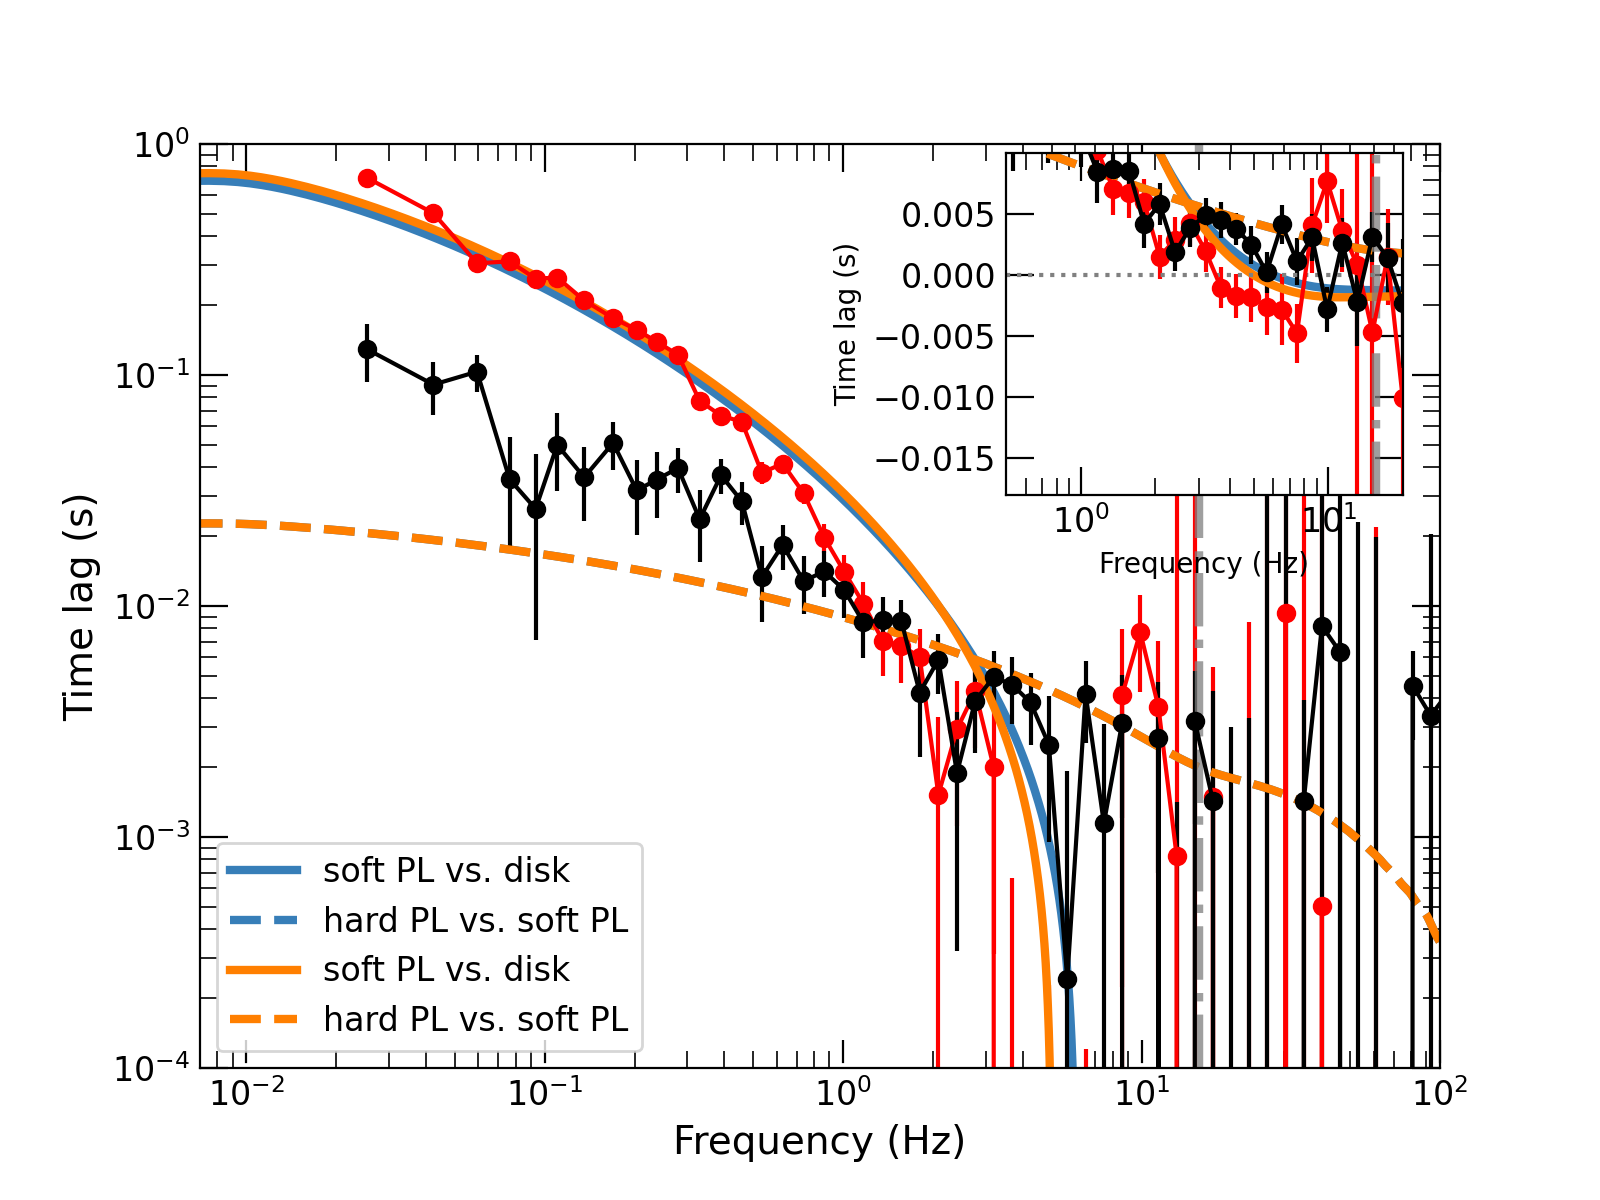

/Users/philuttley/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:118: UserWarning: FixedFormatter should only be used together with FixedLocator


In [22]:
plot_params = params
vlines_list = []
laglist = []
psdlist = []
irflist = []
bandflist = []
ls_list = ['solid','dashed','dotted']
t_scale=5e-5
psdcor_list = [True,True]
pdfrac_list = [1.,0.]
#disk_en_list = [0.1,1.0]
disk_en_list = [1.87,1.87]
label_list = [r'soft PL vs. disk',r'hard PL vs. soft PL']

for i, kTvar_val in enumerate([True,True]):
    plot_params['pow_disk_frac'].value = pdfrac_list[i]
    plot_params['disk_en'].min = 0.1*disk_en_list[i]
    plot_params['disk_en'].value = disk_en_list[i]

    gamma_mean, freq, phlag, tlag, psd_ci, psd_ref, tau, i_rcor, i_rsigmax, rad, deltau,\
    ldisk_disp, lseed_disp,lheat, ldisk_rev, lseed_rev, flux_irf_mono, mod_sig_psd,\
        disk_irf_mono, bandfrac = lagmodel(plot_params, None, None, None, encomb_in, rout=1000, nrad=100, nphi=100, nz=400, 
        cor_geometry=uml.inv_cone, t_scale=5e-5, e_seed=1.0, ens_mono=np.array([1.,3.,9.]), 
        gamma_par=[2.33,0.1], band_calc=True, encomb=np.array([[2,0],[3,2]]), nirf_mult=8, 
        min_deltau_frac=1, freq_rsigmax=0.01, kTvar=kTvar_val, psd_correct=psdcor_list[i], 
                                           lor_model='continuous')
    print("Value",plot_params['disk_en'].value)
#    bandflist.append(bandfrac*(ldisk_disp+lseed_disp))
    bandflist.append(disk_irf_mono) 
    for j in range(2):
        if j == 0:
            labtxt = kTvar_val
            ydata = disktlags_data
            ydata_err = disktlags_err_data
        else:
            labtxt = None
            ydata = powtlags_data
            ydata_err = powtlags_err_data
        print(tlag[j,:])
        laglist.append([np.copy(freq),np.real(1)*np.copy(tlag[j,:]),CBcol[i],ls_list[j],label_list[j],
                        freq_data,ydata,ydata_err,None])
        if j == 0:
            ydata = diskvssoft_psdratio
            ydata_err = diskvssoft_err_psdratio
        else:
            ydata = softvshard_psdratio
            ydata_err = softvshard_err_psdratio
        psdlist.append([np.copy(freq),psd_ref[j,:]/psd_ci[j,:],CBcol[i],ls_list[j],
                        labtxt,freq_data,ydata,ydata_err,False])
        irflist.append([[disk_irf_mono/np.sum(disk_irf_mono),lseed_disp+lseed_rev,lheat],rad,deltau,i_rcor,i_rsigmax,CBcol[i],'test'])

        
    vlines_list.append([1./(tau[i_rcor]*t_scale),'gray','dashdot'])
#        psdlist.append([np.copy(freq),freq*psd_ref[j,:],CBcol[i],ls_list[j],labtxt,freq_data,ydata,ydata_err])
#vlines_list.append([1./(tau[i_rcor]*t_scale),'gray','dashdot'])

freqlim = [0.007,100.0]
freqlim_in = [0.5,20.0]
tlaglim = [0.0001,1]
tlaglim_in = [-0.018,0.01]
psdlim = [0.1,10.5]
inset_yticks = [-0.015,-0.01,-0.005,0,0.005]
axis_names = ['Frequency (Hz)','Time lag (s)',r'$P/P_{\Sigma \; \dot{m}(r)}$']
#figfile = 'figs/lagspsd_invcone_mono_hcorcompare.pdf'
figfile = None
#leg_title=r'$r_{\rm cor}=10$ $R_{g}$, $\theta_{\rm cor}=30^{\circ}$'
leg_title = None
#plot_data_lags_psds(laglist, psdlist, vlines_list, axis_names, freqlim, tlaglim, tlaglim_in, psdlim, 
#               inset_yticks, leg_title, figfile) 

inputs = [True,True]
plot_data_lags(inputs, laglist, vlines_list, axis_names, freqlim, freqlim_in, tlaglim, tlaglim_in, inset_yticks, 
                   leg_title, figfile)



In [31]:
set_function = Minimizer(lagmodel, params, fcn_args=(freq_in, data_in, err_in, encomb_in), nan_policy='omit')
#out = minimize(residual, params, args=())
#result = set_function.minimize(method = 'leastsq')
result = set_function.minimize(method = 'leastsq')
report_fit(result)

Minimum frequency = 0.01 Hz and maximum signal radius =  74.71839315451066 Rg
Disk band IRF PL frac:  0.20171808640409597
Disk band total PL frac:  [0.23134382]
#######################################
Time bin size dt is:  0.002140046877148988
The maximum propagation delay is:  32.29628819661545  and there are  524288  irf bins.
Minimum frequency = 0.01 Hz and maximum signal radius =  74.71839315451066 Rg
Disk band IRF PL frac:  0.20171808640409597
Disk band total PL frac:  [0.23134382]
#######################################
Time bin size dt is:  0.002140046877148988
The maximum propagation delay is:  32.29628819661545  and there are  524288  irf bins.
Minimum frequency = 0.01 Hz and maximum signal radius =  74.71839315451066 Rg
Disk band IRF PL frac:  0.20171808640409597
Disk band total PL frac:  [0.23134382]
#######################################
Time bin size dt is:  0.002140046877148988
The maximum propagation delay is:  32.29628819661545  and there are  524288  irf bins.
Minimum

Minimum frequency = 0.01 Hz and maximum signal radius =  64.59215129376639 Rg
Disk band IRF PL frac:  0.07456933716857049
Disk band total PL frac:  [0.09176846]
#######################################
Time bin size dt is:  0.0021640530335722847
The maximum propagation delay is:  32.33251184785813  and there are  524288  irf bins.
Minimum frequency = 0.01 Hz and maximum signal radius =  64.59215129376639 Rg
Disk band IRF PL frac:  0.07456933644423247
Disk band total PL frac:  [0.09176845]
#######################################
Time bin size dt is:  0.0021640530335722847
The maximum propagation delay is:  32.33251184785813  and there are  524288  irf bins.
Minimum frequency = 0.01 Hz and maximum signal radius =  64.59215129376639 Rg
Disk band IRF PL frac:  0.07456933693657737
Disk band total PL frac:  [0.09176845]
#######################################
Time bin size dt is:  0.0021640530335722847
The maximum propagation delay is:  32.33251184785813  and there are  524288  irf bins.
Mini

Minimum frequency = 0.01 Hz and maximum signal radius =  56.06099957749845 Rg
Disk band IRF PL frac:  0.0975363213625497
Disk band total PL frac:  [0.12313456]
#######################################
Time bin size dt is:  0.00473985348111706
The maximum propagation delay is:  30.24876375350317  and there are  262144  irf bins.
Minimum frequency = 0.01 Hz and maximum signal radius =  56.06099957749845 Rg
Disk band IRF PL frac:  0.09753632096438179
Disk band total PL frac:  [0.12313456]
#######################################
Time bin size dt is:  0.00473985348111706
The maximum propagation delay is:  30.24876375350317  and there are  262144  irf bins.
Minimum frequency = 0.01 Hz and maximum signal radius =  56.06099957749845 Rg
Disk band IRF PL frac:  0.0975363215587018
Disk band total PL frac:  [0.12313456]
#######################################
Time bin size dt is:  0.00473985348111706
The maximum propagation delay is:  30.24876375350317  and there are  262144  irf bins.
Minimum freq

Minimum frequency = 0.01 Hz and maximum signal radius =  55.7905507848717 Rg
Disk band IRF PL frac:  0.10006554139562816
Disk band total PL frac:  [0.12719339]
#######################################
Time bin size dt is:  0.004816789621987855
The maximum propagation delay is:  30.58242005078509  and there are  262144  irf bins.
Minimum frequency = 0.01 Hz and maximum signal radius =  55.7905507848717 Rg
Disk band IRF PL frac:  0.10006554161848805
Disk band total PL frac:  [0.12719339]
#######################################
Time bin size dt is:  0.004816789621987855
The maximum propagation delay is:  30.58242005078509  and there are  262144  irf bins.
Minimum frequency = 0.01 Hz and maximum signal radius =  55.7905507848717 Rg
Disk band IRF PL frac:  0.10006554123210512
Disk band total PL frac:  [0.12719339]
#######################################
Time bin size dt is:  0.004816789621987855
The maximum propagation delay is:  30.58242005078509  and there are  262144  irf bins.
Minimum fr

Minimum frequency = 0.01 Hz and maximum signal radius =  55.68644553794373 Rg
Disk band IRF PL frac:  0.10088894090425238
Disk band total PL frac:  [0.12853379]
#######################################
Time bin size dt is:  0.004845428527477064
The maximum propagation delay is:  30.66514592816623  and there are  262144  irf bins.
Minimum frequency = 0.01 Hz and maximum signal radius =  55.68644516746538 Rg
Disk band IRF PL frac:  0.10088893332473736
Disk band total PL frac:  [0.12853378]
#######################################
Time bin size dt is:  0.004845428500249091
The maximum propagation delay is:  30.665145371754924  and there are  262144  irf bins.
Minimum frequency = 0.01 Hz and maximum signal radius =  55.68644516746538 Rg
Disk band IRF PL frac:  0.1008889337065713
Disk band total PL frac:  [0.12853378]
#######################################
Time bin size dt is:  0.004845428500249091
The maximum propagation delay is:  30.665145371754924  and there are  262144  irf bins.
Minimu

Minimum frequency = 0.01 Hz and maximum signal radius =  55.684071843202275 Rg
Disk band IRF PL frac:  0.10112940305922138
Disk band total PL frac:  [0.12883285]
#######################################
Time bin size dt is:  0.0048461916252080794
The maximum propagation delay is:  30.669758787643435  and there are  262144  irf bins.
Minimum frequency = 0.01 Hz and maximum signal radius =  55.684325868235156 Rg
Disk band IRF PL frac:  0.1011044396763679
Disk band total PL frac:  [0.12880178]
#######################################
Time bin size dt is:  0.004846110488971987
The maximum propagation delay is:  30.6692850979746  and there are  262144  irf bins.
Minimum frequency = 0.01 Hz and maximum signal radius =  55.684325868235156 Rg
Disk band IRF PL frac:  0.10110443849658024
Disk band total PL frac:  [0.12880178]
#######################################
Time bin size dt is:  0.004846110496386048
The maximum propagation delay is:  30.669285010103803  and there are  262144  irf bins.
Min

Minimum frequency = 0.01 Hz and maximum signal radius =  55.68426955344648 Rg
Disk band IRF PL frac:  0.10111009089590191
Disk band total PL frac:  [0.12880881]
#######################################
Time bin size dt is:  0.004846128496204318
The maximum propagation delay is:  30.66939054057329  and there are  262144  irf bins.


<IPython.core.display.Javascript object>


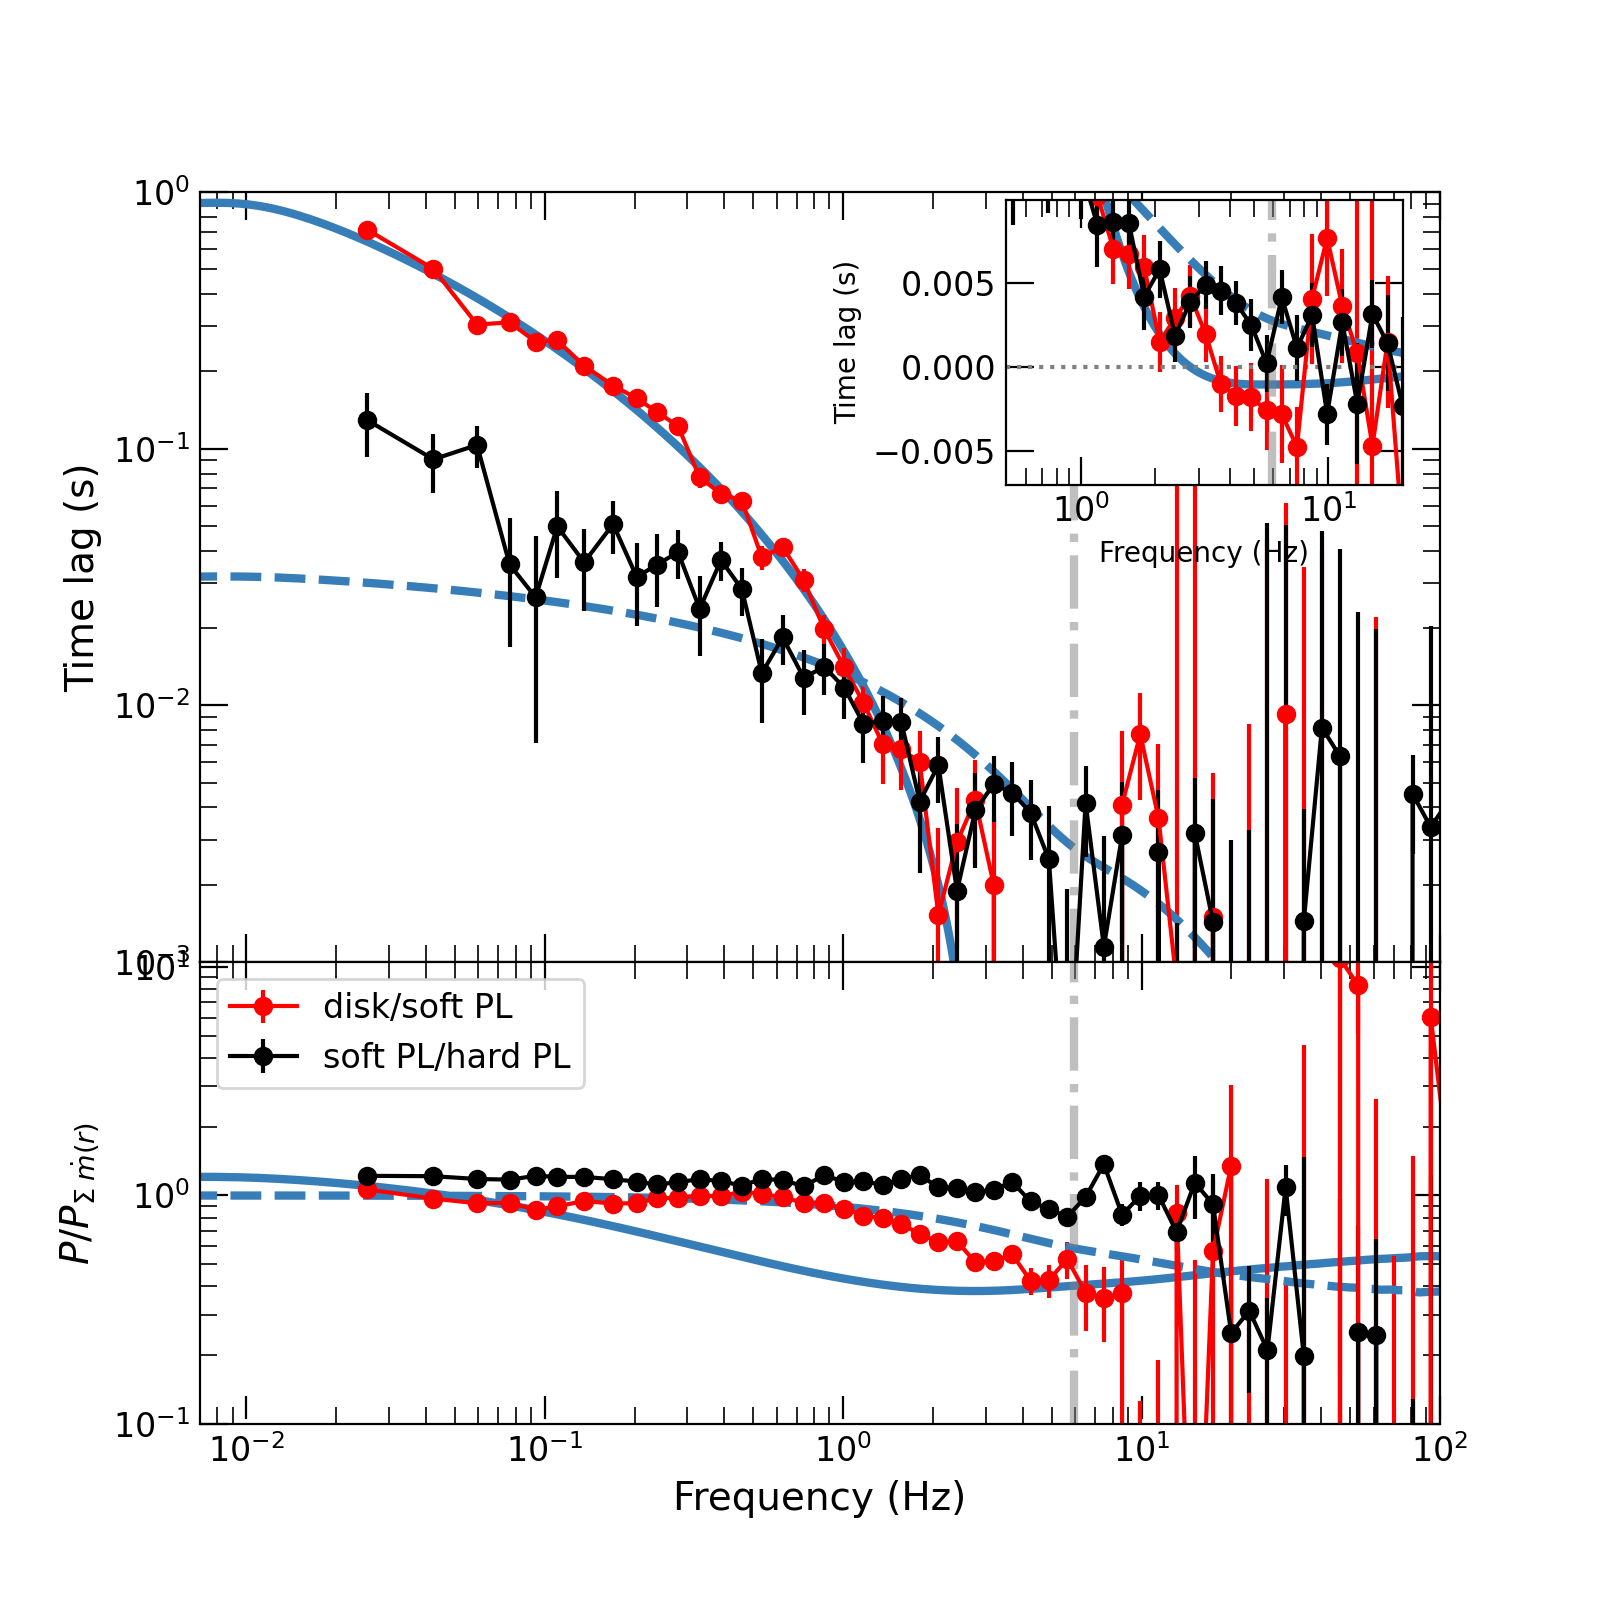

/Users/philuttley/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: UserWarning: FixedFormatter should only be used together with FixedLocator


In [32]:
plot_params = result.params
#plot_params['delay_tau_scale'].value = 2.0
#plot_params = params

gamma_mean, freq, phlag, tlag, psd_ci, psd_ref, tau, i_rcor, i_rsigmax, rad, deltau,\
ldisk_disp, lseed_disp,lheat, ldisk_rev, lseed_rev, flux_irf_mono, mod_sig_psd,\
        disk_irf_mono, bandfrac = lagmodel(plot_params, None, None, None, encomb_in, rout=1000, nrad=100, nphi=100, nz=400, 
        cor_geometry=uml.inv_cone, t_scale=5e-5, e_seed=1.0, ens_mono=np.array([1.,3.,9.]), 
        gamma_par=[2.33,0.167], band_calc=True, encomb=np.array([[2,0],[3,2]]), nirf_mult=8, 
        min_deltau_frac=1, freq_rsigmax=0.01, kTvar=True, psd_correct=True)
vlines_list = []
laglist = []
psdlist = []
ls_list = ['solid','dashed','dotted']
t_scale=5e-5

for j in range(2):
    if j == 0:
        ydata = disktlags_data
        ydata_err = disktlags_err_data
        data_label = r'soft PL (2-3 keV) vs. disk (0.5-0.9 keV)'
    else:
        ydata = powtlags_data
        ydata_err = powtlags_err_data
        data_label = r'hard PL (6-9 keV) vs. soft PL (2-3 keV)'
    laglist.append([np.copy(freq),np.copy(tlag[j,:]),CBcol[0],ls_list[j],None,freq_data,
                    ydata,ydata_err,data_label,True])
    if j == 0:
        ydata = diskvssoft_psdratio
        ydata_err = diskvssoft_err_psdratio
        data_label = r'disk/soft PL'
    else:
        ydata = softvshard_psdratio
        ydata_err = softvshard_err_psdratio
        data_label = r'soft PL/hard PL'
    psdlist.append([np.copy(freq),psd_ref[j,:]/psd_ci[j,:],CBcol[0],ls_list[j],None,freq_data,
                    ydata,ydata_err,data_label,True])

vlines_list.append([1./(tau[i_rcor]*t_scale),'gray','dashdot'])
#        psdlist.append([np.copy(freq),freq*psd_ref[j,:],CBcol[i],ls_list[j],labtxt,freq_data,ydata,ydata_err])
#vlines_list.append([1./(tau[i_rcor]*t_scale),'gray','dashdot'])

freqlim = [0.007,100.0]
freqlim_in = [0.5,20]
tlaglim = [0.001,1]
tlaglim_in = [-0.007,0.01]
psdlim = [0.1,10.5]
inset_yticks = [-0.005,0,0.005]
axis_names = ['Frequency (Hz)','Time lag (s)',r'$P/P_{\Sigma \; \dot{m}(r)}$']
#fig_file = 'figs/lagsdata_invcone_mono_tauind1p9hcor10rcor8ang6.pdf'
fig_file = None
#leg_title=r'$r_{\rm cor}=10$ $R_{g}$, $\theta_{\rm cor}=30^{\circ}$'
leg_title = None
inputs = [True,True]

#laglist = [[None,None,CBcol[0],ls_list[0],None,freq_data,disktlags_data,disktlags_err_data,r'soft PL (2-3 keV) vs. disk (2-3 keV)'],
#           [None,None,CBcol[0],ls_list[0],None,freq_data,powtlags_data,powtlags_err_data,r'hard PL (6-9 keV) vs. soft PL (2-3 keV)']]

#plot_data_lags(inputs, laglist, vlines_list, axis_names, freqlim, freqlim_in, tlaglim, tlaglim_in, inset_yticks, 
#                   leg_title=None, figfile=fig_file)

plot_data_lags_psds(laglist, psdlist, vlines_list, axis_names, freqlim, freqlim_in, tlaglim, tlaglim_in, psdlim, 
               inset_yticks, leg_title, fig_file)    
    

In [ ]:
set_function = Minimizer(lagmodel, params, fcn_args=(freq_in, data_in, err_in, encomb_in), nan_policy='omit')
#out = minimize(residual, params, args=())
result2 = set_function.minimize(method = 'leastsq')
report_fit(result2)

In [ ]:
plot_params = result2.params
#plot_params['delay_tau_scale'].value = 2.0
#plot_params = params

gamma_mean, freq, phlag, tlag, psd_ci, psd_ref, tau, i_rcor, i_rsigmax, rad, deltau,\
ldisk_disp, lseed_disp,lheat, ldisk_rev, lseed_rev, flux_irf_mono, mod_sig_psd,\
        disk_irf_mono = lagmodel(plot_params, None, None, None, encomb_in, rout=1000, nrad=100, nphi=100, nz=400, 
        cor_geometry=uml.inv_cone, t_scale=5e-5, e_seed=1.0, ens_mono=np.array([1.,3.,9.]), 
        gamma_par=[2.33,0.167], band_calc=True, encomb=np.array([[2,0],[3,2]]), nirf_mult=8, 
        min_deltau_frac=1, freq_rsigmax=0.01, kTvar=True, psd_correct=True)
vlines_list = []
laglist = []
psdlist = []
ls_list = ['solid','dashed','dotted']
t_scale=5e-5

for j in range(2):
    if j == 0:
#        labtxt = r"$h_{\rm cor}$="+str(round(plot_params['hcor'].value))+" $R_{g}$"
        ydata = disktlags_data
        ydata_err = disktlags_err_data
        data_label = r'soft PL (2-3 keV) vs. disk (2-3 keV)'
    else:
#        labtxt = 
        ydata = powtlags_data
        ydata_err = powtlags_err_data
        data_label = r'hard PL (6-9 keV) vs. soft PL (2-3 keV)'
    laglist.append([np.copy(freq),np.copy(tlag[j,:]),CBcol[0],ls_list[j],labtxt,freq_data,ydata,ydata_err,data_label])
    if j == 0:
        ydata = diskvssoft_psdratio
        ydata_err = diskvssoft_err_psdratio
    else:
        ydata = softvshard_psdratio
        ydata_err = softvshard_err_psdratio
    psdlist.append([np.copy(freq),psd_ref[j,:]/psd_ci[j,:],CBcol[0],ls_list[j],labtxt,freq_data,ydata,ydata_err])

vlines_list.append([1./(tau[i_rcor]*t_scale),'gray','dashdot'])
#        psdlist.append([np.copy(freq),freq*psd_ref[j,:],CBcol[i],ls_list[j],labtxt,freq_data,ydata,ydata_err])
#vlines_list.append([1./(tau[i_rcor]*t_scale),'gray','dashdot'])

freqlim = [0.007,100.0]
tlaglim = [0.001,1]
tlaglim_in = [-0.007,0.01]
psdlim = [0.1,10.5]
inset_yticks = [-0.005,0,0.005]
axis_names = ['Frequency (Hz)','Time lag (s)',r'$P/P_{\Sigma \; \dot{m}(r)}$']
fig_file = 'figs/lagsdata_invcone_mono_tauind0hcor10rcor9ang40.pdf'
#figfile = None
leg_title=r'$r_{\rm cor}=10$ $R_{g}$, $\theta_{\rm cor}=30^{\circ}$'
inputs = [True,True]

#laglist = [[None,None,CBcol[0],ls_list[0],None,freq_data,disktlags_data,disktlags_err_data,r'soft PL (2-3 keV) vs. disk (2-3 keV)'],
#           [None,None,CBcol[0],ls_list[0],None,freq_data,powtlags_data,powtlags_err_data,r'hard PL (6-9 keV) vs. soft PL (2-3 keV)']]

plot_data_lags(inputs, laglist, vlines_list, axis_names, freqlim, freqlim_in, tlaglim, tlaglim_in, inset_yticks, 
                   leg_title=None, figfile=fig_file)

#plot_data_lags_psds(laglist, psdlist, vlines_list, axis_names, freqlim, tlaglim, tlaglim_in, psdlim, 
#               inset_yticks, leg_title, figfile)    

In [ ]:
set_function = Minimizer(lagmodel, params, fcn_args=(freq_in, data_in, err_in, encomb_in), nan_policy='omit')
#out = minimize(residual, params, args=())
result3 = set_function.minimize(method = 'leastsq')
report_fit(result3)

In [ ]:
plot_params = result3.params
#plot_params['delay_tau_scale'].value = 2.0
#plot_params = params

gamma_mean, freq, phlag, tlag, psd_ci, psd_ref, tau, i_rcor, i_rsigmax, rad, deltau,\
ldisk_disp, lseed_disp,lheat, ldisk_rev, lseed_rev, flux_irf_mono, mod_sig_psd,\
        disk_irf_mono = lagmodel(plot_params, None, None, None, encomb_in, rout=1000, nrad=100, nphi=100, nz=400, 
        cor_geometry=uml.inv_cone, t_scale=5e-5, e_seed=1.0, ens_mono=np.array([1.,3.,9.]), 
        gamma_par=[2.33,0.167], band_calc=True, encomb=np.array([[2,0],[3,2]]), nirf_mult=8, 
        min_deltau_frac=1, freq_rsigmax=0.01, kTvar=True, psd_correct=True)
vlines_list = []
laglist = []
psdlist = []
ls_list = ['solid','dashed','dotted']
t_scale=5e-5

for j in range(2):
    if j == 0:
#        labtxt = r"$h_{\rm cor}$="+str(round(plot_params['hcor'].value))+" $R_{g}$"
        ydata = disktlags_data
        ydata_err = disktlags_err_data
        data_label = r'soft PL (2-3 keV) vs. disk (2-3 keV)'
    else:
#        labtxt = 
        ydata = powtlags_data
        ydata_err = powtlags_err_data
        data_label = r'hard PL (6-9 keV) vs. soft PL (2-3 keV)'
    laglist.append([np.copy(freq),np.copy(tlag[j,:]),CBcol[0],ls_list[j],labtxt,freq_data,ydata,ydata_err,data_label])
    if j == 0:
        ydata = diskvssoft_psdratio
        ydata_err = diskvssoft_err_psdratio
    else:
        ydata = softvshard_psdratio
        ydata_err = softvshard_err_psdratio
    psdlist.append([np.copy(freq),psd_ref[j,:]/psd_ci[j,:],CBcol[0],ls_list[j],labtxt,freq_data,ydata,ydata_err])

vlines_list.append([1./(tau[i_rcor]*t_scale),'gray','dashdot'])
#        psdlist.append([np.copy(freq),freq*psd_ref[j,:],CBcol[i],ls_list[j],labtxt,freq_data,ydata,ydata_err])
#vlines_list.append([1./(tau[i_rcor]*t_scale),'gray','dashdot'])

freqlim = [0.007,100.0]
tlaglim = [0.001,1]
tlaglim_in = [-0.007,0.01]
psdlim = [0.1,10.5]
inset_yticks = [-0.005,0,0.005]
axis_names = ['Frequency (Hz)','Time lag (s)',r'$P/P_{\Sigma \; \dot{m}(r)}$']
fig_file = 'figs/lagsdata_invcone_mono_tauind0hcor30rcor8ang8.pdf'
#figfile = None
leg_title=r'$r_{\rm cor}=10$ $R_{g}$, $\theta_{\rm cor}=30^{\circ}$'
inputs = [True,True]

#laglist = [[None,None,CBcol[0],ls_list[0],None,freq_data,disktlags_data,disktlags_err_data,r'soft PL (2-3 keV) vs. disk (2-3 keV)'],
#           [None,None,CBcol[0],ls_list[0],None,freq_data,powtlags_data,powtlags_err_data,r'hard PL (6-9 keV) vs. soft PL (2-3 keV)']]

plot_data_lags(inputs, laglist, vlines_list, axis_names, freqlim, freqlim_in, tlaglim, tlaglim_in, inset_yticks, 
                   leg_title=None, figfile=fig_file)

#plot_data_lags_psds(laglist, psdlist, vlines_list, axis_names, freqlim, tlaglim, tlaglim_in, psdlim, 
#               inset_yticks, leg_title, figfile)    

In [ ]:
gamma_mean, freq, phlag, tlag, psd_ci, psd_ref, tau, i_rcor, i_rsigmax, rad, deltau,\
ldisk_disp, lseed_disp,lheat, ldisk_rev, lseed_rev, flux_irf_mono, mod_sig_psd,\
        disk_irf_mono = lagmodel(plot_params, None, None, None, encomb_in, rout=1000, nrad=100, nphi=100, nz=400, 
        cor_geometry=uml.inv_cone, t_scale=5e-5, e_seed=1.0, ens_mono=np.array([1.,3.,9.]), 
        gamma_par=[2.33,0.167], band_calc=True, encomb=np.array([[2,0],[3,2]]), nirf_mult=8, 
        min_deltau_frac=1, freq_rsigmax=0.01, bb_type='static')
vlines_list = []
laglist = []
psdlist = []
ls_list = ['solid','dashed','dotted']
t_scale=5e-5

for j in range(2):
    if j == 0:
        labtxt = r"$h_{\rm cor}$="+str(round(plot_params['hcor'].value))+" $R_{g}$"
        ydata = disktlags_data
        ydata_err = disktlags_err_data
    else:
        labtxt = None
        ydata = powtlags_data
        ydata_err = powtlags_err_data           
    laglist.append([np.copy(freq),np.copy(tlag[j,:]),CBcol[0],ls_list[j],labtxt,freq_data,ydata,ydata_err])
    if j == 0:
        ydata = diskvssoft_psdratio
        ydata_err = diskvssoft_err_psdratio
    else:
        ydata = softvshard_psdratio
        ydata_err = softvshard_err_psdratio
    psdlist.append([np.copy(freq),psd_ref[j,:]/psd_ci[j,:],CBcol[0],ls_list[j],labtxt,freq_data,ydata,ydata_err])

vlines_list.append([1./(tau[i_rcor]*t_scale),'gray','dashdot'])
#        psdlist.append([np.copy(freq),freq*psd_ref[j,:],CBcol[i],ls_list[j],labtxt,freq_data,ydata,ydata_err])
#vlines_list.append([1./(tau[i_rcor]*t_scale),'gray','dashdot'])

freqlim = [0.007,100.0]
tlaglim = [0.001,1]
tlaglim_in = [-0.018,0.01]
psdlim = [0.1,1.5]
inset_yticks = [-0.015,-0.01,-0.005,0,0.005]
axis_names = ['Frequency (Hz)','Time lag (s)',r'$P/P_{\Sigma \; \dot{m}(r)}$']
#figfile = 'figs/lagspsd_invcone_mono_hcorcompare.pdf'
figfile = None
leg_title=r'$r_{\rm cor}=10$ $R_{g}$, $\theta_{\rm cor}=30^{\circ}$'

plot_data_lags_psds(laglist, psdlist, vlines_list, axis_names, freqlim, tlaglim, tlaglim_in, psdlim, 
               inset_yticks, leg_title, figfile)    

In [ ]:
freq_in = [freq_data[freq_data < 20],freq_data[(freq_data > 0.1) & (freq_data < 20)]]
data_in = [disktlags_data[freq_data < 20],powtlags_data[(freq_data > 0.1) & (freq_data < 20)]]
err_in = [disktlags_err_data[freq_data < 20],powtlags_err_data[(freq_data > 0.1) & (freq_data < 20)]]
encomb_in = [1,2]

params = result.params
#params['seedff_norm'].vary = True
params['disp_ind'].vary = True

set_function = Minimizer(lagmodel, params, fcn_args=(freq_in, data_in, err_in, encomb_in), nan_policy='omit')
#out = minimize(residual, params, args=())
result = set_function.minimize(method = 'leastsq')
report_fit(result)

In [ ]:
plot_params = result.params

gamma_mean, freq, phlag, tlag, psd_ci, psd_ref, tau, i_rcor, i_rsigmax, rad, deltau,\
ldisk_disp, lseed_disp,lheat, ldisk_rev, lseed_rev, flux_irf_mono, mod_sig_psd,\
        disk_irf_mono = lagmodel(plot_params, None, None, None, encomb_in, rout=1000, nrad=100, nphi=100, nz=400, 
        cor_geometry=uml.inv_cone, t_scale=5e-5, e_seed=1.0, ens_mono=np.array([1.,3.,9.]), 
        gamma_par=[2.33,0.167], band_calc=True, encomb=np.array([[2,0],[3,2]]), nirf_mult=8, 
        min_deltau_frac=1, freq_rsigmax=0.01)
vlines_list = []
laglist = []
psdlist = []
ls_list = ['solid','dashed','dotted']
t_scale=5e-5

for j in range(2):
    if j == 0:
        labtxt = r"$h_{\rm cor}$="+str(round(plot_params['hcor'].value))+" $R_{g}$"
        ydata = disktlags_data
        ydata_err = disktlags_err_data
    else:
        labtxt = None
        ydata = powtlags_data
        ydata_err = powtlags_err_data           
    laglist.append([np.copy(freq),np.copy(tlag[j,:]),CBcol[0],ls_list[j],labtxt,freq_data,ydata,ydata_err])
    if j == 0:
        ydata = diskvssoft_psdratio
        ydata_err = diskvssoft_err_psdratio
    else:
        ydata = softvshard_psdratio
        ydata_err = softvshard_err_psdratio
    psdlist.append([np.copy(freq),psd_ref[j,:]/psd_ci[j,:],CBcol[0],ls_list[j],labtxt,freq_data,ydata,ydata_err])

vlines_list.append([1./(tau[i_rcor]*t_scale),'gray','dashdot'])
#        psdlist.append([np.copy(freq),freq*psd_ref[j,:],CBcol[i],ls_list[j],labtxt,freq_data,ydata,ydata_err])
#vlines_list.append([1./(tau[i_rcor]*t_scale),'gray','dashdot'])

freqlim = [0.007,100.0]
tlaglim = [0.001,1]
tlaglim_in = [-0.018,0.01]
psdlim = [0.1,1.5]
inset_yticks = [-0.015,-0.01,-0.005,0,0.005]
axis_names = ['Frequency (Hz)','Time lag (s)',r'$P/P_{\Sigma \; \dot{m}(r)}$']
#figfile = 'figs/lagspsd_invcone_mono_hcorcompare.pdf'
figfile = None
leg_title=r'$r_{\rm cor}=10$ $R_{g}$, $\theta_{\rm cor}=30^{\circ}$'

plot_data_lags_psds(laglist, psdlist, vlines_list, axis_names, freqlim, tlaglim, tlaglim_in, psdlim, 
               inset_yticks, leg_title, figfile)    
    